# Project - Recommendation system - Amazon Reviews data

## Import Libraries and Load data

In [14]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset
from surprise import SVD, KNNBaseline, KNNBasic, NMF, NormalPredictor, BaselineOnly, KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from collections import defaultdict
from surprise import accuracy
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from surprise.model_selection import train_test_split
import warnings 
warnings.simplefilter('ignore')

In [2]:
dataset = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])
dataset.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


## Exploratory Data Analysis

In this step we will analyze the shape of the data, reduce data size, drop the Timestamp column since it does not seem to be of great use and analyze the distribution of ratings given by the users. 

In [3]:
## Analyzing the shape of the dataset
print("The dataset has {} rows".format(dataset.shape[0]))
print("The dataset has {} cols".format(dataset.shape[1]))

The dataset has 7824482 rows
The dataset has 4 cols


In [4]:
## Dropping the timestamp column
dataset.drop('timestamp', axis = 'columns', inplace=True)
dataset.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Checking the distribution of Ratings

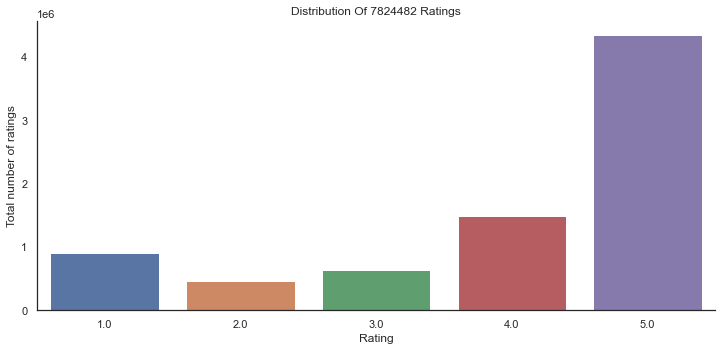

In [5]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=dataset, aspect=2.0,kind='count')
    plt.title('Distribution Of {} Ratings'.format(dataset.shape[0]))
    g.set_ylabels("Total number of ratings")

**Ratings:** we can see that data contains maximum data of ratings = 5 followed by 4 and 1

### Ratings Distribution By Product

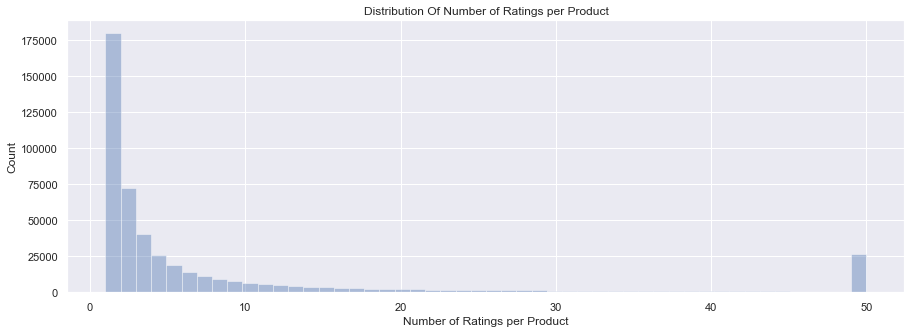

In [6]:
data = dataset.groupby('productId')['Rating'].count().clip(upper=50)
f, axes = plt.subplots(1, 1, figsize=(15, 5))
with sns.axes_style('white'):
    sns.distplot(data, bins = 50, kde = False)
    plt.title('Distribution Of Number of Ratings per Product')
    plt.ylabel('Count')
    plt.xlabel('Number of Ratings per Product')

**Ratings per Product:** We can see that this dataset also contains products with zero ratings count. Less bought products have high ratings

In [7]:
dataset.groupby('productId')['Rating'].count().reset_index().sort_values('Rating', ascending=False)[:10]

,productId,Rating
308398,B0074BW614,18244
429572,B00DR0PDNE,16454
327308,B007WTAJTO,14172
102804,B0019EHU8G,12285
296625,B006GWO5WK,12226
178601,B003ELYQGG,11617
178813,B003ES5ZUU,10276
323013,B007R5YDYA,9907
289775,B00622AG6S,9823
30276,B0002L5R78,9487


**Ratings per Product:** Product *'B0074BW614'* has got the maximum ratings

### Ratings Distribution By User

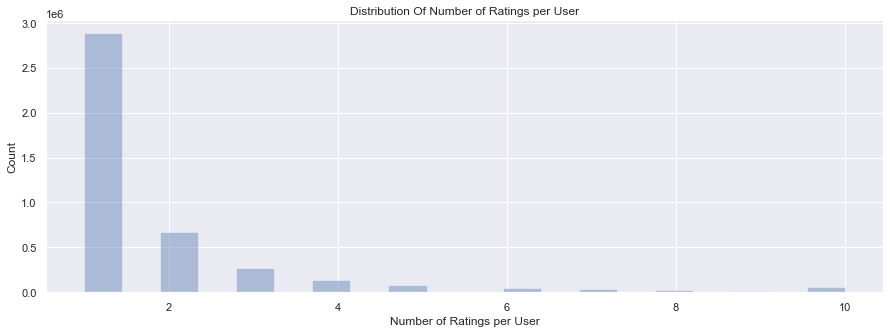

In [8]:
data = dataset.groupby('userId')['Rating'].count().clip(upper=10)

f, axes = plt.subplots(1, 1, figsize=(15, 5))
with sns.axes_style('ticks'):
    sns.distplot(data, bins = 20, kde = False)
    plt.title('Distribution Of Number of Ratings per User')
    plt.ylabel('Count')
    plt.xlabel('Number of Ratings per User')

In [9]:
dataset.groupby('userId')['Rating'].count().reset_index().sort_values('Rating', ascending=False)[:10]

,userId,Rating
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406
755206,A1ODOGXEYECQQ8,380
2424036,A36K2N527TXXJN,314
1451394,A2AY4YUOX2N1BQ,311
4100926,AWPODHOB4GFWL,308
1277963,A25C2M3QF9G7OQ,296


**Ratings per User:** User *'A5JLAU2ARJ0BO'* has given the highest ratings, so appears that he is more active in shopping

## Filter out data for users rated more than 50 times. This will reduce the sparse matrix to little dense one

In [10]:
#keep data of users who have rated more than 50 times
min_user_ratings = 50
filter_users = dataset['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

dataset = dataset[dataset['userId'].isin(filter_users)]
print('The new data frame shape:\t{}'.format(dataset.shape))

The new data frame shape:	(122171, 3)


**Reduce Sparse Matrix:** As seen in above graphs the data contains users who have given rare ratings to many products. So we need to consider only those who have atleast 50 ratings of the products so that we can come with proper model of recommendation

## Popularity Recommender model

In [11]:
dfPopularity = dataset.copy()
# dropping duplicate values 
dfPopularity.drop_duplicates(subset=['userId'] ,keep='first',inplace=True)

Use train test split to break data before applying the popularity model

In [15]:
train_data, test_data = tts(dfPopularity, test_size = 0.30, random_state=0)

#### Product ID aggregation using count on rating

In [16]:
#initialize the recommender model and create using the train data

train_data_grouped = train_data.groupby(['productId','Rating']).agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'}, inplace = True)
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending = 0, method = 'first')
popularity_recommendataions = train_data_sort.head(10)

In [17]:
#use the popularity model to make some prediction on test data and recommend top 10 items
def recommend(user_id):
    user_recommendataion = popularity_recommendataions
    user_recommendataion['userId'] = user_id
    cols = user_recommendataion.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendataion = user_recommendataion[cols]
    return user_recommendataion

users = test_data['userId'].unique()
user_id = users[5]
recommend(user_id)

,userId,productId,Rating,score,Rank
490,AWNJAY0M5UI70,B000067RT6,5.0,13,1.0
325,AWNJAY0M5UI70,B00004ZCJE,5.0,12,2.0
130,AWNJAY0M5UI70,B00001P4ZH,4.0,6,3.0
324,AWNJAY0M5UI70,B00004ZCJE,4.0,6,4.0
430,AWNJAY0M5UI70,B00005T3G0,5.0,6,5.0
323,AWNJAY0M5UI70,B00004ZCJE,3.0,5,6.0
149,AWNJAY0M5UI70,B00001WRSJ,5.0,4,7.0
154,AWNJAY0M5UI70,B00001ZWXA,5.0,4,8.0
228,AWNJAY0M5UI70,B00004T8R2,4.0,4,9.0
229,AWNJAY0M5UI70,B00004T8R2,5.0,4,10.0


In [18]:
# create test dataset later used in RMSE calculation
dfCountRatingTest = recommend(user_id)
dfCountRatingTest

,userId,productId,Rating,score,Rank
490,AWNJAY0M5UI70,B000067RT6,5.0,13,1.0
325,AWNJAY0M5UI70,B00004ZCJE,5.0,12,2.0
130,AWNJAY0M5UI70,B00001P4ZH,4.0,6,3.0
324,AWNJAY0M5UI70,B00004ZCJE,4.0,6,4.0
430,AWNJAY0M5UI70,B00005T3G0,5.0,6,5.0
323,AWNJAY0M5UI70,B00004ZCJE,3.0,5,6.0
149,AWNJAY0M5UI70,B00001WRSJ,5.0,4,7.0
154,AWNJAY0M5UI70,B00001ZWXA,5.0,4,8.0
228,AWNJAY0M5UI70,B00004T8R2,4.0,4,9.0
229,AWNJAY0M5UI70,B00004T8R2,5.0,4,10.0


In [19]:
#combined rmse value
y_test = dfCountRatingTest.Rating
y_pred = 5 
rss = ((y_test-y_pred)**2).sum()
mse=np.mean((y_test-y_pred)**2)
print("Final rmse value is =", np.sqrt(np.mean((y_test-y_pred)**2)))

Final rmse value is = 0.8366600265340756


#### Product ID aggregation using mean on rating

In [20]:
train_data_grouped = train_data.groupby(['userId', 'productId']).agg({'Rating': 'mean'}).reset_index()
train_data_sort = train_data_grouped.sort_values(['userId', 'productId'], ascending = [0,1])
popularity_recommendataions = train_data_sort.head(10)

In [21]:
# Method to item created recommendations
def recommend(item_id):
    item_recommendataion = popularity_recommendataions
    item_recommendataion['productId'] = item_id
    cols = item_recommendataion.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    item_recommendataion = item_recommendataion[cols]

    return item_recommendataion

products = test_data['productId'].unique()
item_id = products[5]
recommend(item_id)

,Rating,userId,productId
1025,5.0,AZOK5STV85FBJ,B00005RI9I
1024,4.0,AZNUHQSHZHSUE,B00005RI9I
1023,5.0,AZMY6E8B52L2T,B00005RI9I
1022,4.0,AZCE11PSTCH1L,B00005RI9I
1021,4.0,AZBXKUH4AIW3X,B00005RI9I
1020,4.0,AZ8XSDMIX04VJ,B00005RI9I
1019,4.0,AZ515FFZ7I2P7,B00005RI9I
1018,3.0,AYOTEJ617O60K,B00005RI9I
1017,5.0,AYOMAHLWRQHUG,B00005RI9I
1016,5.0,AYO1146CBIV5C,B00005RI9I


In [22]:
dfMeanRatingTest = recommend(item_id)
dfMeanRatingTest

,Rating,userId,productId
1025,5.0,AZOK5STV85FBJ,B00005RI9I
1024,4.0,AZNUHQSHZHSUE,B00005RI9I
1023,5.0,AZMY6E8B52L2T,B00005RI9I
1022,4.0,AZCE11PSTCH1L,B00005RI9I
1021,4.0,AZBXKUH4AIW3X,B00005RI9I
1020,4.0,AZ8XSDMIX04VJ,B00005RI9I
1019,4.0,AZ515FFZ7I2P7,B00005RI9I
1018,3.0,AYOTEJ617O60K,B00005RI9I
1017,5.0,AYOMAHLWRQHUG,B00005RI9I
1016,5.0,AYO1146CBIV5C,B00005RI9I


In [23]:
#combined rmse value
y_test = dfMeanRatingTest.Rating 
y_pred = 5 
rss=((y_test-y_pred)**2).sum()
mse=np.mean((y_test-y_pred)**2)
print("Final rmse value is =",np.sqrt(np.mean((y_test-y_pred)**2)))

Final rmse value is = 0.9486832980505138


##### Summary for Popularity Model:

Count Based Approach: The RMSE calculated on test data is = 0.83

Mean Based Approach: The RMSE calculated on test data is = 0.94, here we have kept same product and ranked in by different users

## Collaborative Filtering model

In [24]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(dataset, reader)

In [25]:
benchmark = []
# Iterate over all algorithms
# SVD/NMF are model based approaches
# non-parametric KNN** are the memory based approaches

for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.979739,0.281463,0.215259
SVD,0.983640,4.685683,0.442098
KNNBaseline,1.043950,0.345024,0.814382
KNNWithMeans,1.067273,0.120348,0.815653
KNNBasic,1.109949,0.110366,0.696530
NMF,1.149682,8.152150,0.267939
NormalPredictor,1.366431,0.124012,0.364336


BaseLineOnly performed well, with RMSE closer to zero.

Train and Predict

In [26]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.974928  , 0.97302994, 0.98272808]),
 'fit_time': (0.25161004066467285, 0.2009117603302002, 0.1690833568572998),
 'test_time': (0.18952608108520508, 0.20545077323913574, 0.18248224258422852)}

In [27]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9760


0.9760159011578531

##### Summary Report of Collaborative Model

Base Line Only : Among different models, Base Line performed much better with an RMSE = 0.9760

## Get top - K ( K = 5) recommendations

In [28]:
dfCountRatingTest.head()

,userId,productId,Rating,score,Rank
490,AWNJAY0M5UI70,B000067RT6,5.0,13,1.0
325,AWNJAY0M5UI70,B00004ZCJE,5.0,12,2.0
130,AWNJAY0M5UI70,B00001P4ZH,4.0,6,3.0
324,AWNJAY0M5UI70,B00004ZCJE,4.0,6,4.0
430,AWNJAY0M5UI70,B00005T3G0,5.0,6,5.0


In [29]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [30]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:5]
worst_predictions = df.sort_values(by='err')[-5:]

In [31]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
20055,A1XXMNLOLKNO0I,B001TOD7ME,5.0,5.0,{'was_impossible': False},77,37,0.0
10640,A1XXMNLOLKNO0I,B00008OT2G,5.0,5.0,{'was_impossible': False},77,2,0.0
19630,A3DOPYDOS49I3T,B004TLH6H6,5.0,5.0,{'was_impossible': False},80,7,0.0
25065,A2THQCHKR89E16,B002V88HFE,5.0,5.0,{'was_impossible': False},35,73,0.0
11896,A64LEAZ2QF8L2,B00429N18S,5.0,5.0,{'was_impossible': False},47,22,0.0


**Best Predictions :** We can see that the error = 0, meaning these are the actual users who really bought the item and then rated it.

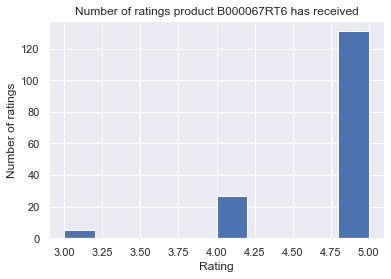

In [32]:
dataset.loc[dataset['productId'] == 'B000N99BBC']['Rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings product B000067RT6 has received')
plt.show();

In [33]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
10525,A1REY92IEZJUSX,B00752R4PK,1.0,4.978134,{'was_impossible': False},37,9,3.978134
7543,A9ELHLPXF7JKD,B009C3M7H0,1.0,5.000000,{'was_impossible': False},58,6,4.000000
29123,A1MFPAM9TTRTXN,B00123WZWK,1.0,5.000000,{'was_impossible': False},47,4,4.000000
29062,A9BWUH9XKZ2DQ,B00006RVPW,1.0,5.000000,{'was_impossible': False},31,24,4.000000
1645,AZMY6E8B52L2T,B004G6002M,1.0,5.000000,{'was_impossible': False},137,36,4.000000


**Worst Predictions :** Here we see the error values > 0. This shows that these users may not have actually bought the item but just being influenced by others or they themselves have gone through the reviews of others, based on which they have rated the item

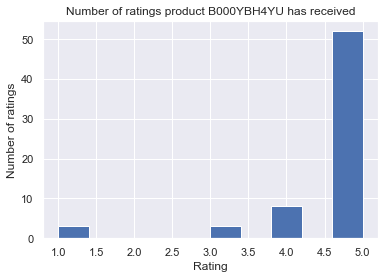

In [34]:
dataset.loc[dataset['productId'] == 'B0002L5R78']['Rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings product B000YBH4YU has received')
plt.show();

## Final Thoughts

Collaborative Modelling is much better than the Popularity based modelling. Here the item-item and user-user way of identifying the associations and then ranking them has more impact and netter accuracy compared to the popularity based models where we rely solely on for example ranking and based on it recommend items to others. Though in this dataset the RMSE of Count based Popularity model is less than compared to Mean and Collaborative based. We can use the Popularity model to recommend the electronic items for this dataset

__________________________________________